<a href="https://colab.research.google.com/github/escape13/deepfried/blob/master/CNN/CIFAR10/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset

In [45]:
import torch
import numpy as np
from torchvision import datasets, transforms

In [46]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [47]:
train_data = datasets.CIFAR10('train/', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('test/', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [48]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, shuffle=True)

In [49]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Visualizing the dataset

In [50]:
import matplotlib.pyplot as plt

In [51]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

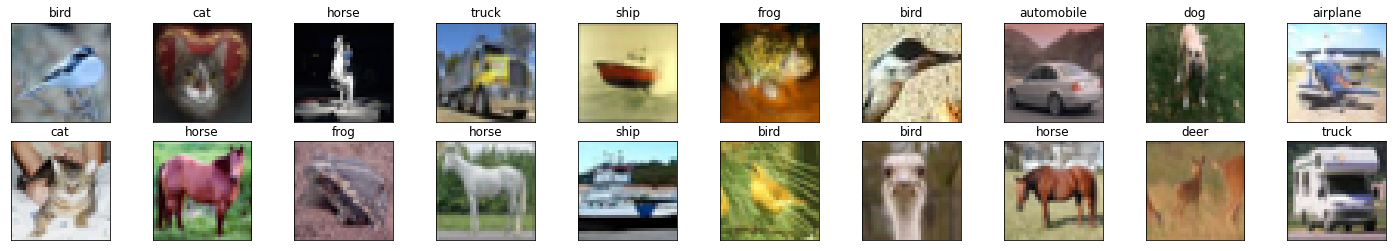

In [52]:
images, labels = iter(train_loader).next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

# Defining the architecture

In [53]:
from torch import nn
import torch.nn.functional as F

In [62]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        self.dropout = nn.Dropout(p=0.25)

        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 64 * 4 * 4)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


# Training the network

In [63]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

Epoch 1: 	 Training Loss: 2.0187278804779054 	 Validation Loss: 0.3247821922302246
Epoch 2: 	 Training Loss: 1.5538471942663192 	 Validation Loss: 0.28678320746421815
Epoch 3: 	 Training Loss: 1.3859739382505416 	 Validation Loss: 0.25958336367607115
Epoch 4: 	 Training Loss: 1.271443750166893 	 Validation Loss: 0.23231726181507112
Epoch 5: 	 Training Loss: 1.1769726865291597 	 Validation Loss: 0.21661342129707337
Epoch 6: 	 Training Loss: 1.0927155272245408 	 Validation Loss: 0.2005689947962761
Epoch 7: 	 Training Loss: 1.0276400915622712 	 Validation Loss: 0.19024736717939378
Epoch 8: 	 Training Loss: 0.9710496374845504 	 Validation Loss: 0.18446748979091646
Epoch 9: 	 Training Loss: 0.9148918984413147 	 Validation Loss: 0.17346465178728104
Epoch 10: 	 Training Loss: 0.8691176340103149 	 Validation Loss: 0.16506130006313324
Epoch 11: 	 Training Loss: 0.8265417507648468 	 Validation Loss: 0.16098961762189865
Epoch 12: 	 Training Loss: 0.7825149698555469 	 Validation Loss: 0.1591008338

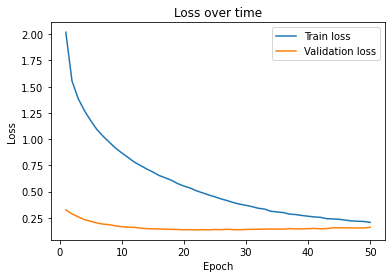

In [64]:
num_epochs = 50

train_size = len(train_loader)
test_size = len(test_loader)

train_losses = []
valid_losses = []
     
valid_loss_min = np.Inf

for epoch in range(1, num_epochs+1):

    train_loss = 0
    model.train()

    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    with torch.no_grad():

        valid_loss = 0
        model.eval()
        for images, labels in test_loader:
            output = model.forward(images)
            loss = criterion(output, labels)
            valid_loss += loss.item()

        train_loss = train_loss/train_size
        valid_loss = valid_loss/valid_size

        print(f"Epoch {epoch}: \t Training Loss: {train_loss} \t Validation Loss: {valid_loss}")

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), 'model_dict.pt')
            valid_loss_min = valid_loss

plt.plot(range(1, num_epochs+1), train_losses, label='Train loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.legend()

# Testing the network

In [66]:
model.load_state_dict(torch.load('model_dict.pt'))

test_size = len(test_loader)
right_guesses = 0

with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        output = model(images)
        output = F.softmax(output)
        top_p, top_class = output.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        equals = equals.type(torch.FloatTensor)
        right_guesses += torch.sum(equals).item()

print(f"Accuracy: {right_guesses*100/(test_size*20)}%")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


Accuracy: 77.04%
